In [1]:

# xgboost
import xgboost
print("xgboost", xgboost.__version__)

xgboost 1.2.0


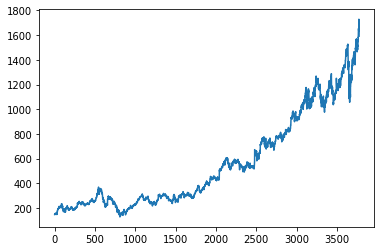

In [4]:

# load and plot the time series dataset
from pandas import read_csv
from matplotlib import pyplot
# load dataset
series1 = read_csv('GOOG.csv', header=0, index_col=0)
series=series1['Close']
values = series.values
# plot dataset
pyplot.plot(values)
pyplot.show()

C:\Users\cmozk\anaconda3\lib\site-packages\xgboost\data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


>expected=1581.8, predicted=1526.4
>expected=1580.4, predicted=1510.4
>expected=1588.2, predicted=1550.6
>expected=1608.2, predicted=1518.9
>expected=1652.4, predicted=1579.6
>expected=1634.3, predicted=1615.8
>expected=1644.4, predicted=1610.0
>expected=1634.2, predicted=1640.5
>expected=1660.7, predicted=1637.2
>expected=1728.3, predicted=1645.6
>expected=1641.8, predicted=1725.7
>expected=1591.0, predicted=1710.6
MAE: 57.823


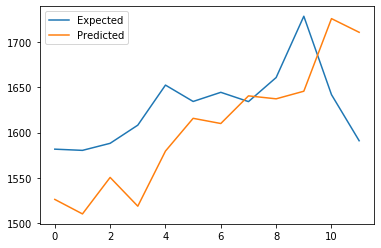

In [11]:
# forecast with xgboost
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot
 
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[0]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]
 
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(asarray([testX]))
	return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions
 
# load the dataset

# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

numpy.ndarray

In [12]:
# finalize model and make a prediction with xgboost
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from xgboost import XGBRegressor
 
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[0]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values
 

# transform the time series data into supervised learning
train = series_to_supervised(values, n_in=6)
# split into input and output columns
trainX, trainy = train[:, :-1], train[:, -1]
# fit model
model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
model.fit(trainX, trainy)
# construct an input for a new preduction
row = values[-6:].flatten()
# make a one-step prediction
yhat = model.predict(asarray([row]))
print('Input: %s, Predicted: %.3f' % (row, yhat[0]))

Input: [1644.410034 1634.180054 1660.709961 1728.280029 1641.839966 1591.040039], Predicted: 1616.750
